# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
#импорт билиотек
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

RANDOM_STATE = 12345

In [2]:
#импорт данных
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('C:\\datasets/users_behavior.csv')

In [3]:
#выводим первые 5 строк датафрейма
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
#основная информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
#основные статистики датафрейма
data.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


**Вывод**
<br>Действительно, предобработка данных не требуется. Данные выглядят довольно однородными - без аномалий и резких выбросов.

## Разбейте данные на выборки

In [6]:
#определим целевой признак и прочие
target = data['is_ultra']
features = data.drop('is_ultra', axis=1)

In [7]:
#разобьем все данные на обучающую, валидационную и тестовую выборки (60/20/20)
features_train, features_vnt, target_train, target_vnt = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_vnt, target_vnt, test_size=0.5, random_state=RANDOM_STATE, stratify=target_vnt)

In [8]:
#проверяем результат
features_train.shape

(1928, 4)

In [9]:
features_valid.shape

(643, 4)

In [10]:
features_train.shape[0]/data.shape[0]

0.5998755444928439

**Вывод**
<br>Имеем 3 выборки: обучающую (60% исходных данных), валидационную (20%) и тестовую (20%).

## Исследуйте модели

**Дерево решений**

Рассмотрим точность предсказаний модели дерева решений с различным параметром max_depth:

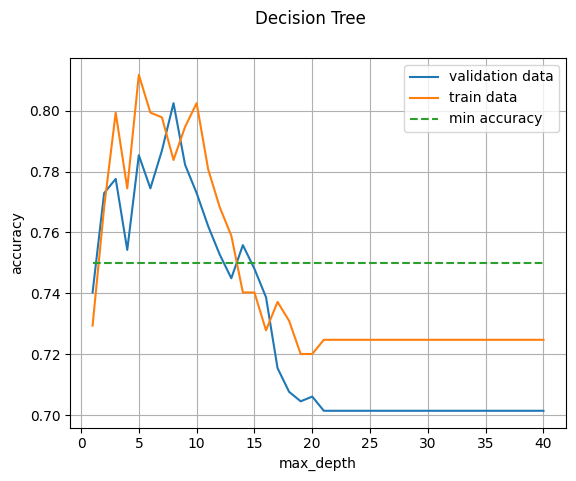

In [11]:
dtc_accuracy = []
train_accuracy =[]
for depth in range(1,41):
    dtc_model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    dtc_model.fit(features_train, target_train)
    predictions_valid = dtc_model.predict(features_valid)
    dtc_accuracy.append(accuracy_score(target_valid, predictions_valid))
    train_accuracy.append(accuracy_score(target_test, dtc_model.predict(features_test)))
#строим график по полученным значениям
plt.plot([i+1 for i in range(len(dtc_accuracy))], dtc_accuracy);
plt.plot([i+1 for i in range(len(dtc_accuracy))], train_accuracy);
plt.plot([i+1 for i in range(len(dtc_accuracy))], [0.75 for i in range(len(dtc_accuracy))], '--');
plt.suptitle('Decision Tree')
plt.legend (('validation data', 'train data', 'min accuracy'))
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.grid()

Точность предсказания на валидационой выборке растет нестабильно, иногда приближаясь к пороговому значению (0.75). Только с глубины >= 5 можно говорить о хорошей точности предсказания. При больших значениях параметра max_depth видим переобучение.

**Случайный лес**

Рассмотрим точность предсказаний модели случайного леса с различным параметром n_estimators (1-40) и max_depth (1-20):

In [12]:
%%time
rfc_accuracy = pd.DataFrame(columns=[i for i in range(1,21)], index=[i for i in range(1,41)])
for depth in range(1, 21):
    for est in range(1, 41):
        rfc_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        rfc_model.fit(features_train, target_train)
        rfc_accuracy.loc[est, depth] = rfc_model.score(features_valid, target_valid)

CPU times: total: 1min 54s
Wall time: 2min 22s


In [13]:
rfc_accuracy = rfc_accuracy.astype(float)

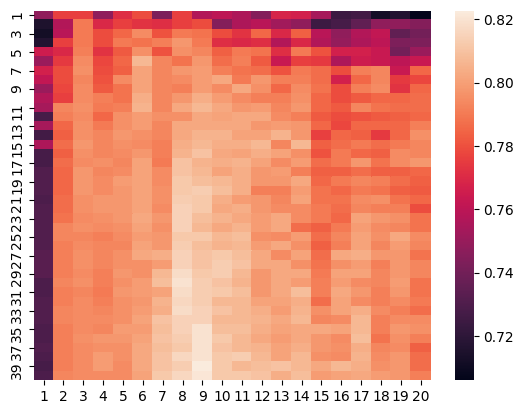

In [14]:
sns.heatmap(rfc_accuracy);

Оптимальные значения получаем с параметрами n_estimators=39 и max_depth=9

**Логистическая регрессия**

Рассмотрим точность предсказаний модели логистической регрессии с различными гиперпараметрами:

In [15]:
%%time
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for i in range(len(solvers)):
    lr_model = LogisticRegression(random_state=RANDOM_STATE, solver=solvers[i], max_iter=10000)
    lr_model.fit(features_train, target_train)
    predictions_valid = lr_model.predict(features_valid)
    print('solver =', solvers[i], 'accuracy =', f'{accuracy_score(target_valid, predictions_valid):.3f}')

C:\Users\user\.conda\envs\ds_practicum_env\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\.conda\envs\ds_practicum_env\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\.conda\envs\ds_practicum_env\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\.conda\envs\ds_practicum_env\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


solver = newton-cg accuracy = 0.739
solver = lbfgs accuracy = 0.739
solver = liblinear accuracy = 0.719
solver = sag accuracy = 0.712
solver = saga accuracy = 0.711
CPU times: total: 2.94 s
Wall time: 3.29 s


Как видно, здесь мы не можем перешагнуть порог точности в 0.75 ни в одном из вариантов.

**Вывод**
<br>Наилучшие значения точности на валидационной выборке достигаются с моделью случайного леса  параметрами n_estimators=39 и max_depth=9

## Проверьте модель на тестовой выборке

Обучаем модель на объединенной обучающей + валидационной выборках. Проверяем выбранную модель на тестовой выборке:

In [16]:
rfc_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=39, max_depth=9)
rfc_model.fit(pd.concat([features_train, features_valid], ignore_index=True, axis=0, sort=False),
              pd.concat([target_train, target_valid], ignore_index=True, axis=0, sort=False))
print('accuracy:', f"{rfc_model.score(features_test, target_test):.3f}")

accuracy: 0.829


**Вывод**
<br>На тестовой выборке получено значение точности выше 0.75. С помощью RandomForestClassifier мы добились точности 0.829 с гиперпараметрами n_estimators=39 и max_depth=9.

## (бонус) Проверьте модели на адекватность

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(pd.concat([features_train, features_valid], ignore_index=True, axis=0, sort=False),
                pd.concat([target_train, target_valid], ignore_index=True, axis=0, sort=False))
print('accuracy:', f"{dummy_model.score(features_test, target_test):.3f}")

accuracy: 0.694


**Вывод**
<br>0.694 - Базовая "точность" константной модели. Все используемые модели по своей точности ее превосходят, включая оптимальную.